# Forces in the simulation

The simulation part of 'icenumerics' is done through the 'magcolloids' package, which works as a wrapper of the molecular dynamics program [LAMMPS](https://lammps.sandia.gov/doc/Manual.html). In molecular dynamics, the equations of motion of all particles are solved by discretizing them, and applying a velocity verlet algorithm. The equations of motion are given by Newton's equation: 
$$m_i\ddot{\vec{x_i}} = \vec{F_i}$$

## Brownian Dynamics
The 'icenumerics' and 'magcolloids' packages use a modified version of LAMMPS, to instead run Brownian dynamics. In Brownian dynamics, particles are assumed to be immersed in a high Reynolds number fluid, so that:
* A viscous drag force is included in the force balance, which is proportional to the velocity $F_{i,drag} = -\gamma\dot{\vec{x_i}}$. 
* This viscous force is assumed to be much larger than the inertial term $m_i\vec{\ddot{x_i}}$, so the later can be neglected.
* Particles are subjected to random kicks from the fluid. These are given by a Langevin thermostat which is a random variable $\eta$ such that $\left<\eta\right> = 0$ and $\left<\eta_i(t+\Delta t)\eta_j(t)\right> = 2k_BT\gamma\delta({i-j})\delta({\Delta t})$, where $\delta$ is the Dirac delta function.

The result from these assumptions is that the force balance can be written:
$$\gamma\dot{\vec{x_i}} = \vec{F_i} + \eta$$

which can be discretized as:

$$\Delta{\vec{x_i}} = \frac{\Delta t}{\gamma}\vec{F_i} + \sqrt{\Delta t 2k_BT\gamma}N[0,1]$$ 

where $N[0,1]$ is a Gaussian distributed random variable with zero mean and unitary variance. 
This is the equation that is used to solve the trajectories of particles.

## Available Forces 

In [1]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../../../')

import icenumerics as ice
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("error")

There are two components that are fundamental to Colloidal Ice: the trapping force and the interaction force. 

### Trapping Force

Colloidal Ice consists of colloidal particles confined to a bistable potential, so that particles can jump from one stability position to another in a way that minimizes the energy of the system. The potential used by the 'icenumerics' package is a bi-harmonic potential, defined by:

$$
F = -k r_{\perp} \hat{e}_{\perp} + \hat{e}_{||}
\begin{cases}
k \left(|r_{||}|-d/2\right) \mathrm{sign}\left(r_{||}\right) & r_{||}<d/2 \\
h(1-4r_{||}^2/d^2)  & r_{||}>d/2
\end{cases}
$$

where $r_{||}$ is the component parallel to the direction of the trap, and $r_{\perp}$ is the perpendicular component, $\hat{e}_{||}$ is the unit vector in the direction of the trap, $\hat{e}_{||}$ a vector pointing away from the line that joins both stable points, $k$ is the trap stiffness, $d$ is the distance between centers, and $h$ is the stiffness of the central hill. 

#### A note on the stiffness of the central hill. 
The `height` parameter determines the difference in potential energy from the energy minimum, to the center to the trap, which is the maximum of the hill. Internally this is implemented as a harmonic potential with a stiffness $k_{hill} = \frac{8h}{d^2}$ where $d$ is the distance between traps. 

The above expression can be checked by allowing a particle to diffuse thermally through a trap, and observing its probability distribution. To do this, we run a single particle on a single trap. 

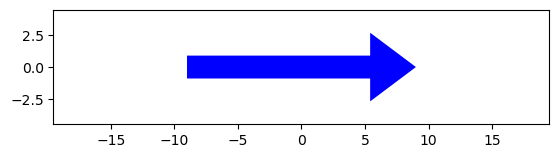

In [2]:
ureg = ice.ureg
sp = ice.spins(centers = np.array([[0,0,0]])*ureg.um, 
               directions = np.array([[30,0,0]])*ureg.um, 
               lattice_constant=10*ureg.um)
sp.display()

In [3]:
particle = ice.particle(radius = 1*ureg.um,
             susceptibility = 0,
             diffusion = 0.145*ureg.um**2/ureg.s,
             temperature = 300*ureg.K)

trap = ice.trap(trap_sep = 2*ureg.um,
               height = 16*ureg.pN*ureg.nm,
               stiffness = 1*ureg.fN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0)
col.pad_region(3*ureg.um)

world = ice.world(
    field = 0*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

By adding the forces to the simulation's output, we can compare them to the expected function.

In [4]:
%%time 
col.simulation(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = 10*ureg.Hz,
             timestep = 1000*ureg.us,
             run_time = 10000*ureg.s,
             output = ["x","y","z","fx","fy","fz"])

col.run_simulation()
col.load_simulation()

scanning file


  0%|          | 0/34088052 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 5.38 s, total: 1min 35s
Wall time: 3min 32s


Text(0.5, 0, 'P(y)')

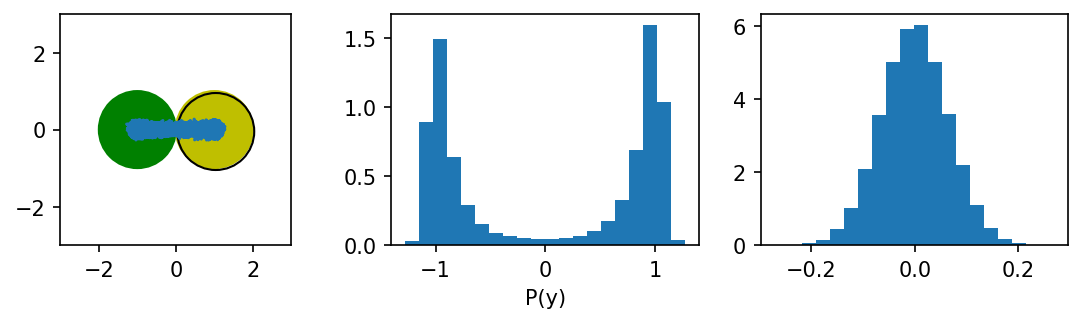

In [5]:
fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

col.display(ax = ax[0])
ax[0].plot(col.trj[col.trj.type==1].x, col.trj[col.trj.type==1].y)

ax[1].hist(col.trj[col.trj.type==1].x, bins=20, density=True);
ax[1].set_xlabel("x")
ax[1].set_xlabel("P(x)")
ax[2].hist(col.trj[col.trj.type==1].y, bins=20, density=True);
ax[1].set_xlabel("x")
ax[1].set_xlabel("P(y)")

Below we define the energy of the bistable trap and it's force. Notice the change in the units of $h$.

In [6]:
k = col[0].trap.stiffness
d = col[0].trap.trap_sep
h = col[0].trap.height.to("pN um")
kB = 1.38064852e-23*ureg.J/ureg.K

def bistable_trap(x,y):
    
    Uy = (k*y**2/2).to("pN nm")
    
    Ux = (h*(1-4 * (x)**2/d**2)).to("pN nm")
    
    Ux1 = (k * (abs(x)-d/2)**2 / 2).to("pN nm")

    Ux[abs(x)>(d/2)] = Ux1[abs(x)>(d/2)]
    
    return Ux+Uy

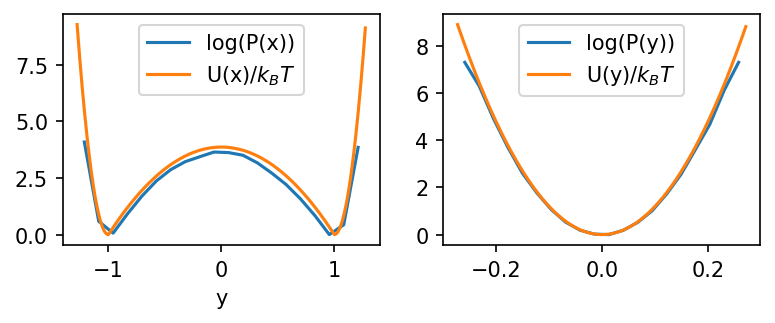

In [7]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)

## parallel dependence
[p, x] = np.histogram(col.trj[col.trj.type==1].x, bins = 20, density=True)
ax[0].plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p), label="log(P(x))")

x = np.linspace(min(x),max(x),1000) * ureg.um
y = np.array([0])*ureg.um
T = col.sim.world.temperature

ax[0].plot(x.magnitude, (bistable_trap(x,y)/(kB*T)).to(" ").magnitude, label="U(x)/$k_BT$")
ax[0].set_xlabel("x")
ax[0].legend()

## perpendicular dependence
[p, y] = np.histogram(col.trj[col.trj.type==1].y, bins = 20, density=True)
ax[1].plot(y[1:]-np.diff(y)/2, max(np.log(p))-np.log(p),label="log(P(y))")

x = np.array([d.magnitude/2])*d.units
y = np.linspace(min(y),max(y),1000) * ureg.um
T = col.sim.world.temperature

ax[1].plot(y.magnitude, (bistable_trap(x,y)/(kB*T)).to(" ").magnitude,label="U(y)/$k_BT$")
ax[0].set_xlabel("y")
ax[1].legend()

We can also compare directly to the forces calculated inside lammps:

In [8]:
def bistable_trap_force(x,y):
    
    Fx1 = -np.sign(x.magnitude)*(abs(x)-d/2)*k
    k_h = h*8/d**2
    Fx = x * k_h
    
    Fx[abs(x)>(d/2)] = Fx1[abs(x)>(d/2)]
    
    Fy = -y*k
    
    Fx = Fx.to("pN")
    Fy = Fy.to("pN")

    return Fx, Fy

Text(0, 0.5, 'Force [pN]')

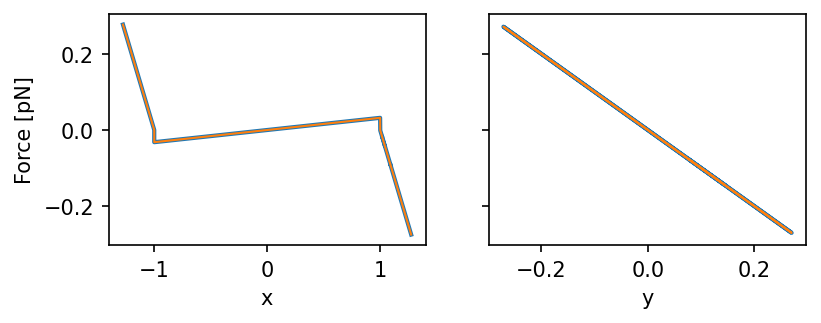

In [9]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150, sharey=True)
forces = col.trj[col.trj.type==1]
forces = forces.sort_values(by="x")

x = forces.x
y = forces.y

fx = forces.fx * (1*ureg.pg*ureg.um/ureg.us**2).to(ureg.pN).magnitude
fy = forces.fy * (1*ureg.pg*ureg.um/ureg.us**2).to(ureg.pN).magnitude

ax[0].plot(x,fx,linewidth = 2)
ax[1].plot(y,fy,linewidth = 2)

Fx, Fy = bistable_trap_force(x.values*ureg.um, y.values*ureg.um)

ax[0].plot(x, Fx.magnitude,linewidth = 1)
ax[0].set_xlabel("x")

ax[1].plot(y,Fy.magnitude,linewidth = 1)
ax[1].set_xlabel("y")
ax[0].set_ylabel("Force [pN]")

## Dipole Dipole interaction

To do...